In [ ]:
!pip install wfdb

     |████████████████████████████████| 122kB 13.0MB/s 
     |████████████████████████████████| 6.8MB 17.4MB/s 
     |████████████████████████████████| 163kB 60.8MB/s 
  Created wheel for wfdb: filename=wfdb-3.1.1-cp36-none-any.whl size=117828 sha256=0412ec5e80b3831262c8a6ec240eaf94562e20aeb9618d3e8ab3738e6a78353b
  Stored in directory: /root/.cache/pip/wheels/bc/d0/c1/90538d266ccba2d1076fbc9970192c7ea1a09c99df3e65c69b
Successfully built wfdb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import wfdb
from random import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ludb/1.0.0/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v4’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2020-12-08 12:07:27 (30.7 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v4’ saved [116/116]

--2020-12-08 12:07:27--  https://physionet.org/files/ludb/1.0.0/67.atr_v5
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v5’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2020-12-08 12:07:27 (29.4 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v5’ saved [116/116]

--2020-12-08 12:07:27--  https://physionet.org/files/ludb/1.0.0/67.atr_v6
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 110 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v6’

physionet.org/files 100%[=======

# data preprocessing and extracting
- LUDB data
- https://arxiv.org/pdf/2001.04689.pdf

In [ ]:
# folder_path = '/mnt/biosignal_DB/LUDB/physionet.org/files/ludb/1.0.0'
# file_list = os.listdir(folder_path)
# record_list = pd.read_csv(os.path.join(folder_path,'RECORDS')).values.ravel()

In [ ]:
folder_path = '/content/physionet.org/files/ludb/1.0.0'
file_list = os.listdir(folder_path)
record_list = pd.read_csv(os.path.join(folder_path,'RECORDS')).values.ravel()

In [ ]:
# wave_len = 600
# for number,pid in enumerate(record_list):
#     print('{}/{}'.format(number,len(record_list)))
#     record = wfdb.rdrecord(os.path.join(folder_path,str(pid)))
#     atr_ii = wfdb.rdann(os.path.join(folder_path,str(pid)),extension='atr_ii')

#     atr_symbols = np.array(atr_ii.symbol)
#     atr_points = atr_ii.sample
#     lead_II_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
#     lead_II = record.p_signal[:,lead_II_idx]

#     p_onset_list = np.where(np.array(atr_symbols)=='p')[0]-1
    
#     #p를 시작점으로 모든 segment를 자르자.
#     for idx,p_onset in enumerate(p_onset_list):
#         p_idx = atr_points[p_onset]
#         lead_seg = lead_II[p_idx:p_idx+wave_len] ##df에 들어가

#         include_symbols_idx = atr_points[(atr_points>=p_idx)&(atr_points<p_idx+600)]

#         # segments 안에 존재하는 symbol list
#         seg_symbols = atr_symbols[np.isin(atr_points,include_symbols_idx)]
#         # 해당 symbol의 seg ECG 상 실제 위치
#         seg_sybols_idx = include_symbols_idx - p_idx

#         unet_label_list = list()
#         unet_label_list.append(lead_seg)
#         for symbol in ['p','N','t']:
#             # seg_symbol list에서 각 심볼 위치
#             PQRS_seg_symbols = np.where(seg_symbols==symbol)[0]

#             # seg_symbol list에서 p onset 위치
#             Onset_seg_symbols = PQRS_seg_symbols-1
#             Offset_seg_symbols = PQRS_seg_symbols+1

#             dummy = np.zeros(wave_len) #df에 들어가
#             for onset,offset in zip(Onset_seg_symbols,Offset_seg_symbols[:len(Onset_seg_symbols)]):
#                 try:
#                     onset_idx = seg_sybols_idx[onset]
#                     offset_idx = seg_sybols_idx[offset]
#                     dummy[onset_idx:offset_idx] =1
#                 except IndexError:
#                     pass
#             unet_label_list.append(dummy)
        
#         if unet_label_list[-1].sum()!=0: # T가 존재해야지만 저장한다.
#             seg_remain = np.logical_or(unet_label_list[1] ,unet_label_list[2])
#             seg_remain = (np.logical_or(seg_remain,unet_label_list[3])-1)*(-1)
#             unet_label_list.append(seg_remain)
            
#             np.save('../data/segments/{}_{}'.format(pid,idx),np.array(unet_label_list))
           
            
        
    


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import re
import wfdb
from wfdb import processing

data_dir = Path('/content/physionet.org/files/ludb/1.0.0')

num_records = 200
records = []
for i in range(1,num_records+1):
    record = wfdb.io.rdrecord(f'{data_dir}/{i}')
    age = 99 if record.comments[0][7:] == '>89' else int(record.comments[0][7:])
    data = {'id': i,
            'age(10)' : age //10 * 10, 
            'sex':record.comments[1][-1],
            'dignosis':record.comments[3:]}
    cols = ['i', 'ii',  'iii',  'avr',  'avl',  'avf',  'v1',  'v2',  'v3',  'v4',  'v5',  'v6']
    for col, j in zip(cols, range(12)):
        ann = wfdb.rdann(f'{data_dir}/{i}', f'atr_{col}')
        data[col] = {'signal':record.p_signal[:, j], 'anno': ann.__dict__['symbol'], 'anno_idx': ann.__dict__['sample']}
    records.append(data)

In [ ]:
wave_length = 750
unet_label = list()

for i in range(200):
  unet_label.append(dict())
  for lead in cols:
    unet_label[i][lead] = list()

for i in range(200):
  for lead in cols:
    pqrst_label = np.array(records[i][lead]['anno']) # ann과 동일
    pqrst_point = np.array(records[i][lead]['anno_idx']) # ann_idx
    # lead_II_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
    # lead_II = record.p_signal[:,lead_II_idx] #리드2의 전체 signal
    lead_signal = records[i][lead]['signal']

    start_points = np.where(np.array(pqrst_label)=='N')[0]-1 # '('의 인덱스로 리턴

    # qrs파('N')를 시작점으로 모든 segment를 자르자.
    for j,start_point in enumerate(start_points):
        start_index = pqrst_point[start_point]
        seg_signal = lead_signal[start_index:start_index+wave_length] # 첫 qrs부터 750길이의 signal

        pqrst_index = pqrst_point[(pqrst_point>=start_index)&(pqrst_point<start_index+wave_length)] # anno_idx 중에 start_index와 start_index+750 사이에 있는 값들

        # segment 안에 존재하는 pqrst list
        seg_labels = pqrst_label[np.isin(pqrst_point,pqrst_index)] 
        # 해당 pqrst의 segment상 인덱스
        seg_labels_index = pqrst_index - start_index

        unet_label_list = list()
        unet_label_list.append(seg_signal)
        for pqrst in ['p','N','t']:
            # 'p','N','t'의 인덱스
            pqrst_peak = np.where(seg_labels==pqrst)[0]

            # seg_labels에서 onset offset 인덱스

            onset_pqrst = pqrst_peak-1
            offset_pqrst = pqrst_peak+1
 
            mask = np.zeros(wave_length) 
            for onset,offset in zip(onset_pqrst[:],offset_pqrst[:len(onset_pqrst)]):
                try:
                    onset_index = seg_labels_index[onset]
                    offset_index = seg_labels_index[offset]
                    mask[onset_index:offset_index] =1
                except IndexError:
                    pass

            unet_label_list.append(mask)
        
        last_mask = np.ones(wave_length)-(unet_label_list[1]+unet_label_list[2]+unet_label_list[3]) # none of above 마스크
        unet_label_list.append(last_mask)

        unet_label[i][lead].append(unet_label_list)


        # if unet_label_list[-1].sum()!=0: # T가 존재해야지만 저장한다.
        #     seg_remain = np.logical_or(unet_label_list[1] ,unet_label_list[2])
        #     seg_remain = (np.logical_or(seg_remain,unet_label_list[3])-1)*(-1)
        #     unet_label_list.append(seg_remain)
            
        #     np.save('../data/segments/{}_{}'.format(pid,idx),np.array(unet_label_list))

In [ ]:
## npy 파일 생성 ##
'''
cols = ['i', 'ii',  'iii',  'avr',  'avl',  'avf',  'v1',  'v2',  'v3',  'v4',  'v5',  'v6']
for i in range(len(unet_label)):
  for j in range(len(unet_label[i])):
    for k in range(len(unet_label[i][cols[j]])):
      ##try:
        # print(unet_label[i][cols[j]][k])
      np.save('/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/data/segments/{}_{}'.format(str(i),str(k)),np.array(unet_label_list[i][cols[j]][k]))
      ##except:
      ##  print("error")
      ## np.save('/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/data/segments/{}_{}'.format(i,k),np.array(unet_label_list))
'''

'\ncols = [\'i\', \'ii\',  \'iii\',  \'avr\',  \'avl\',  \'avf\',  \'v1\',  \'v2\',  \'v3\',  \'v4\',  \'v5\',  \'v6\']\nfor i in range(len(unet_label)):\n  for j in range(len(unet_label[i])):\n    for k in range(len(unet_label[i][cols[j]])):\n      ##try:\n        # print(unet_label[i][cols[j]][k])\n      np.save(\'/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/data/segments/{}_{}\'.format(str(i),str(k)),np.array(unet_label_list[i][cols[j]][k]))\n      ##except:\n      ##  print("error")\n      ## np.save(\'/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/data/segments/{}_{}\'.format(i,k),np.array(unet_label_list))\n'

In [ ]:
## 학습 데이터 input 형태 ##
unet_label[0]['i'][0]

[array([-6.99921445e+01, -1.59989526e+01, -7.80047133e+01, -8.70123069e+01,
        -1.79890024e+01, -7.20083792e+01, -7.70096884e+01, -6.60120450e+01,
        -8.70123069e+01, -1.43990573e+02, -1.37994239e+02, -1.31997905e+02,
        -1.09007594e+02, -7.20083792e+01,  5.49882168e+01,  9.69887405e+01,
         1.54988217e+02,  3.17989002e+02,  5.66012045e+02,  7.45011783e+02,
         9.78999738e+02,  1.12000524e+03,  1.31000262e+03,  1.39800995e+03,
         1.51901021e+03,  1.49499869e+03,  1.44998691e+03,  1.33100288e+03,
         1.15399319e+03,  8.14008903e+02,  6.56009427e+02,  5.30007855e+02,
         2.63000786e+02,  8.99973815e+01,  4.99869076e+01, -5.79994763e+01,
        -2.69965960e+01,  3.69992145e+01,  1.19926682e+01, -4.99869076e+01,
        -2.50065462e+01, -1.00026185e+01, -4.20005237e+01, -7.80047133e+01,
        -5.10081173e+01, -6.49908353e+01, -5.49882168e+01, -5.89945012e+01,
        -7.20083792e+01, -1.09007594e+02, -5.20031422e+01, -7.99947630e+01,
        -8.7

In [ ]:
'''
wave_len = 600
for number,pid in enumerate(record_list):
    if (number % 10 == 0):
      print('{}/{}'.format(number,len(record_list)))
    record = wfdb.rdrecord(os.path.join(folder_path,str(pid)))
    atr_ii = wfdb.rdann(os.path.join(folder_path,str(pid)),extension='atr_ii')

    atr_symbols = np.array(atr_ii.symbol)
    atr_points = atr_ii.sample
    lead_II_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
    lead_II = record.p_signal[:,lead_II_idx]

    p_onset_list = np.where(np.array(atr_symbols)=='p')[0]-1
    
    #p를 시작점으로 모든 segment를 자르자.
    for idx,p_onset in enumerate(p_onset_list):
        p_idx = atr_points[p_onset]
        lead_seg = lead_II[p_idx:p_idx+wave_len] ##df에 들어가

        include_symbols_idx = atr_points[(atr_points>=p_idx)&(atr_points<p_idx+600)]

        # segments 안에 존재하는 symbol list
        seg_symbols = atr_symbols[np.isin(atr_points,include_symbols_idx)]
        # 해당 symbol의 seg ECG 상 실제 위치
        seg_sybols_idx = include_symbols_idx - p_idx

        unet_label_list = list()
        unet_label_list.append(lead_seg)
        for symbol in ['p','N','t']:
            # seg_symbol list에서 각 심볼 위치
            PQRS_seg_symbols = np.where(seg_symbols==symbol)[0]

            # seg_symbol list에서 p onset 위치
            Onset_seg_symbols = PQRS_seg_symbols-1
            Offset_seg_symbols = PQRS_seg_symbols+1

            dummy = np.zeros(wave_len) #df에 들어가
            for onset,offset in zip(Onset_seg_symbols,Offset_seg_symbols[:len(Onset_seg_symbols)]):
                try:
                    onset_idx = seg_sybols_idx[onset]
                    offset_idx = seg_sybols_idx[offset]
                    dummy[onset_idx:offset_idx] =1
                except IndexError:
                    pass
            unet_label_list.append(dummy)
        
        if unet_label_list[-1].sum()!=0: # T가 존재해야지만 저장한다.
            seg_remain = np.logical_or(unet_label_list[1] ,unet_label_list[2])
            seg_remain = (np.logical_or(seg_remain,unet_label_list[3])-1)*(-1)
            unet_label_list.append(seg_remain)
            
            np.save('/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/data/segments/{}_{}'.format(pid,idx),np.array(unet_label_list))
'''

"\nwave_len = 600\nfor number,pid in enumerate(record_list):\n    if (number % 10 == 0):\n      print('{}/{}'.format(number,len(record_list)))\n    record = wfdb.rdrecord(os.path.join(folder_path,str(pid)))\n    atr_ii = wfdb.rdann(os.path.join(folder_path,str(pid)),extension='atr_ii')\n\n    atr_symbols = np.array(atr_ii.symbol)\n    atr_points = atr_ii.sample\n    lead_II_idx = np.where(np.array(record.sig_name)=='ii')[0][0]\n    lead_II = record.p_signal[:,lead_II_idx]\n\n    p_onset_list = np.where(np.array(atr_symbols)=='p')[0]-1\n    \n    #p를 시작점으로 모든 segment를 자르자.\n    for idx,p_onset in enumerate(p_onset_list):\n        p_idx = atr_points[p_onset]\n        lead_seg = lead_II[p_idx:p_idx+wave_len] ##df에 들어가\n\n        include_symbols_idx = atr_points[(atr_points>=p_idx)&(atr_points<p_idx+600)]\n\n        # segments 안에 존재하는 symbol list\n        seg_symbols = atr_symbols[np.isin(atr_points,include_symbols_idx)]\n        # 해당 symbol의 seg ECG 상 실제 위치\n        seg_sybols_idx = inclu

# segment data load

In [ ]:
N=10
# 임의의 값을 선언 10번째 값을 불러옴!

1234
10


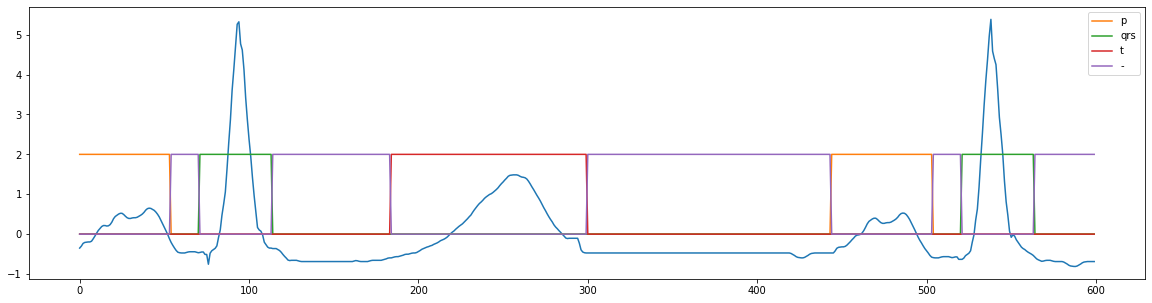

In [ ]:
seg_flielist = os.listdir('/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/data/segments/')
print(len(seg_flielist))

seg_file_df = pd.DataFrame([[filename.split('_')[0],filename]for filename in seg_flielist],columns=['pid','filename'])
seg_file_df = seg_file_df.sort_values(['pid','filename']) ## pid와 filename에 대해서 오름차순 정렬
seg_file_df['filepath'] = seg_file_df.filename.apply(lambda x : os.path.join('/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/data/segments/',x)) ## filepath 열 추가로 생성
seg_file_df = seg_file_df[seg_file_df.pid!='.ipynb']

seg = np.load(os.path.join('/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/data/segments',seg_file_df.filename.tolist()[N])) ## N번째 파일 하나만 따로 불러옴


plt.figure(figsize=(20, 5))
plt.plot((seg[0]-np.mean(seg[0]))/np.std(seg[0])) ## 이거 그래프 높이 맞춰줄라고 하는거 같음 (signal을 평균으로 빼서 표준편차로 나눠줌)
plt.plot((seg[1]*2),label='p')
plt.plot((seg[2]*2),label='qrs')
plt.plot((seg[3]*2),label='t')
plt.plot(seg[4]*2,label='-')
plt.legend()
print(N)
N+=1

In [ ]:
seg_file_df

,pid,filename,filepath
283,10,10_0.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...
927,10,10_1.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...
1093,10,10_2.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...
755,10,10_3.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...
793,10,10_4.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...
...,...,...,...
928,99,99_5.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...
1037,99,99_6.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...
209,99,99_7.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...
966,99,99_8.npy,/content/drive/MyDrive/2020-2 Deep Learning/팀프...


In [ ]:
seg

array([[ -78.99894467,  -71.0085934 ,  -60.00301523, ..., -134.00799035,
        -134.00799035, -134.00799035],
       [   1.        ,    1.        ,    1.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    1.        ,
           1.        ,    1.        ]])

# dataset

In [ ]:
class segment_dataset(Dataset):
    def __init__(self,file_df):
        self.filepath = file_df.filepath.tolist()
        
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self,item):
        try:
            seg = np.load(self.filepath[item])
            ecg_II = (seg[0]-np.mean(seg[0]))/np.std(seg[0])
            mask_arr = seg[1:,:]
        except:
            print(self.filepath[item])
        
        return torch.from_numpy(ecg_II).unsqueeze(0),torch.from_numpy(mask_arr)
        
        
'''
  입력받은 Dataset에서 파일경로, 파일경로 길이(?), 해당부분에 ecg data를 추출해서
  ecg_II <- 그래프 높이를 동일하게 적용
  mask_arr <- p, qrs, t, normal 부분을 추출

  torch.from_numpy = numpy array인 ndarray로부터 텐서를 만든다. 이 함수는 데이터를 복사가 아닌 참조를 한다.
  unsqeeze(0) = parameter 위치에 길이 0짜리 차원을 추가한 텐서를 만든다. ## 이부분은 왜 한건지 잘 모르겠음..
'''

'\n  입력받은 Dataset에서 파일경로, 파일경로 길이(?), 해당부분에 ecg data를 추출해서\n  ecg_II <- 그래프 높이를 동일하게 적용\n  mask_arr <- p, qrs, t, normal 부분을 추출\n\n  torch.from_numpy = numpy array인 ndarray로부터 텐서를 만든다. 이 함수는 데이터를 복사가 아닌 참조를 한다.\n  unsqeeze(0) = parameter 위치에 길이 0짜리 차원을 추가한 텐서를 만든다. ## 이부분은 왜 한건지 잘 모르겠음..\n'

# model structure

In [ ]:
class CBR_1D(nn.Module):
    def __init__(self,in_channels,out_channels,kernel=9,stride=1,padding=4):
        super().__init__()
        self.seq_list = [
        nn.Conv1d(in_channels,out_channels,kernel,stride,padding,bias=False), ## 시계열 데이터처리에 많이 사용되는 1D convolution       
        nn.BatchNorm1d(out_channels),
        nn.ReLU()]  
        '''
        Parameters
        in_channels: input의 feature dimension
        out_channels: 내가 output으로 내고싶은 dimension
        kernel_size: time step을 얼마만큼 볼 것인가(=frame size = filter size)
        stride: kernel을 얼마만큼씩 이동하면서 적용할 것인가 (Default: 1)
        dilation: kernel 내부에서 얼마만큼 띄어서 kernel을 적용할 것인가 (Default: 1)
        padding: 한 쪽 방향으로 얼마만큼 padding할 것인가 (그 만큼 양방향으로 적용) (Default: 0)
        groups: kernel의 height를 조절
        bias: bias term을 둘 것인가 안둘 것인가 (Default: True)
        padding_mode: 'zeros', 'reflect', 'reflect', 'replicate', 'circular' (Default: 'zeros')  
        '''
        ## Batch Normalization : 각 레이어마다 Normalization을 하는 레이어를 두어, 변형된 분포가 나오지 않도록 하는 것이다. 
        ## 미니배치 마다 normalization을 한다는 뜻에서 Batch Normalization이라고 한다. ### https://wegonnamakeit.tistory.com/47
        ## 활성화 함수 중 sigmoid에서 문제가 발생할 수 있어서 ReLU를 사용하기도 한다.                  
        
        self.seq = nn.Sequential(*self.seq_list)
        
    def forward(self,x):
        return self.seq(x)


In [ ]:
# class Unet_1D(nn.Module):
#     def __init__(self,class_n):
#         super().__init__()
        
#         ### ------- encoder -----------
#         self.enc1_1 = CBR_1D(1,4)
#         self.enc1_2 = CBR_1D(4,4)
#         self.enc1_3 = CBR_1D(4,4)
        
#         self.enc2_1 = CBR_1D(4,8)
#         self.enc2_2 = CBR_1D(8,8)
        
#         self.enc3_1 = CBR_1D(8,16)
#         self.enc3_2 = CBR_1D(16,16)
        
#         self.enc4_1 = CBR_1D(16,32)
#         self.enc4_2 = CBR_1D(32,32)
        
# #         self.enc5_1 = CBR_1D(32,64)
# #         self.enc5_2 = CBR_1D(64,64)
        
# #         self.upsample_1 = nn.ConvTranspose1d(kernel_size=8,stride=2,padding=3)
# #         self.dec4_1 = CBR_1D(32+64,32)
# #         self.dec4_2 = CBR_1D(32,32)
        
#         ### ------- decoder -----------
#         self.upsample_3 = nn.ConvTranspose1d(32,32,kernel_size=8,stride=2,padding=3)
#         self.dec3_1 = CBR_1D(16+32,16)
#         self.dec3_2 = CBR_1D(16,16)
        
#         self.upsample_2 = nn.ConvTranspose1d(16,16,kernel_size=8,stride=2,padding=3)
#         self.dec2_1 = CBR_1D(8+16,8)
#         self.dec2_2 = CBR_1D(8,8)
        
#         self.upsample_1 = nn.ConvTranspose1d(8,8,kernel_size=8,stride=2,padding=3)
#         self.dec1_1 = CBR_1D(4+8,4)
#         self.dec1_2 = CBR_1D(4,4)
#         self.dec1_3 = CBR_1D(4,4)
#         self.dec1_4 = CBR_1D(4,class_n)
        
#     def forward(self,x):
        
#         enc1 = self.enc1_1(x)
#         enc1 = self.enc1_2(enc1)
#         enc1 = self.enc1_3(enc1)
        
#         enc2 = nn.functional.max_pool1d(enc1,2)
#         enc2 = self.enc2_1(enc2)
#         enc2 = self.enc2_2(enc2)
        
#         enc3 = nn.functional.max_pool1d(enc2,2)
#         enc3 = self.enc3_1(enc3)
#         enc3 = self.enc3_2(enc3)
        
#         enc4 = nn.functional.max_pool1d(enc3,2)        
#         enc4 = self.enc4_1(enc4)
#         enc4 = self.enc4_2(enc4)
        
#         dec3 = self.upsample_3(enc4)
#         dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1))
#         dec3 = self.dec3_2(dec3)
        
#         dec2 = self.upsample_2(dec3)
#         dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1))
#         dec2 = self.dec2_2(dec2)
        
#         dec1 = self.upsample_1(dec2)
#         dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1))
#         dec1 = self.dec1_2(dec1)
#         dec1 = self.dec1_3(dec1)
#         out = self.dec1_4(dec1)
        
#         return out

In [ ]:

class Unet_1D(nn.Module):
    def __init__(self,class_n,layer_n):
        super().__init__()
        
        ### ------- encoder -----------
        self.enc1_1 = CBR_1D(1,layer_n)
        self.enc1_2 = CBR_1D(layer_n,layer_n)
        self.enc1_3 = CBR_1D(layer_n,layer_n)
        
        self.enc2_1 = CBR_1D(layer_n,layer_n*2)
        self.enc2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.enc3_1 = CBR_1D(layer_n*2,layer_n*4)
        self.enc3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.enc4_1 = CBR_1D(layer_n*4,layer_n*8)
        self.enc4_2 = CBR_1D(layer_n*8,layer_n*8)
        
#         self.enc5_1 = CBR_1D(32,64)
#         self.enc5_2 = CBR_1D(64,64)
        
#         self.upsample_1 = nn.ConvTranspose1d(kernel_size=8,stride=2,padding=3)
#         self.dec4_1 = CBR_1D(32+64,32)
#         self.dec4_2 = CBR_1D(32,32)
        
        ### ------- decoder -----------
        self.upsample_3 = nn.ConvTranspose1d(layer_n*8,layer_n*8,kernel_size=8,stride=2,padding=3) ## https://medium.com/@santi.pdp/how-pytorch-transposed-convs1d-work-a7adac63c4a5
        self.dec3_1 = CBR_1D(layer_n*4+layer_n*8,layer_n*4)
        self.dec3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.upsample_2 = nn.ConvTranspose1d(layer_n*4,layer_n*4,kernel_size=8,stride=2,padding=3)
        self.dec2_1 = CBR_1D(layer_n*2+layer_n*4,layer_n*2)
        self.dec2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.upsample_1 = nn.ConvTranspose1d(layer_n*2,layer_n*2,kernel_size=8,stride=2,padding=3)
        self.dec1_1 = CBR_1D(layer_n*1+layer_n*2,layer_n*1)
        self.dec1_2 = CBR_1D(layer_n*1,layer_n*1)
        self.dec1_3 = CBR_1D(layer_n*1,class_n)
        self.dec1_4 = CBR_1D(class_n,class_n)

        '''
      Unet 관련해서 그때 그림으로 봤었던 encoding, decoding 해주는 부분
      4개의 클래스, 6개의 layer로 입력을 받는다.
      클래스는 인코딩/디코딩 관련한 갯수이고 layer는 학습 층을 뜻하는거 같은데 확실하게 이해를 못해서 그림으로는 못그릴거 같다.

      ConvTranspose1d = 여러 입력 평면으로 구성된 입력 이미지에 1D transpose Convolution 연산자를 적용합니다.
        '''
        
        
    ### 이부분은 forward 하는 부분이어서 pass!
    def forward(self,x):
        
        enc1 = self.enc1_1(x)
        enc1 = self.enc1_2(enc1)
        enc1 = self.enc1_3(enc1)
        
        enc2 = nn.functional.max_pool1d(enc1,2)
        enc2 = self.enc2_1(enc2)
        enc2 = self.enc2_2(enc2)
        
        enc3 = nn.functional.max_pool1d(enc2,2)
        enc3 = self.enc3_1(enc3)
        enc3 = self.enc3_2(enc3)
        
        enc4 = nn.functional.max_pool1d(enc3,2)        
        enc4 = self.enc4_1(enc4)
        enc4 = self.enc4_2(enc4)
        
        dec3 = self.upsample_3(enc4)
        dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1))
        dec3 = self.dec3_2(dec3)
        
        dec2 = self.upsample_2(dec3)
        dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1))
        dec2 = self.dec2_2(dec2)
        
        dec1 = self.upsample_1(dec2)
        dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1))
        dec1 = self.dec1_2(dec1)
        dec1 = self.dec1_3(dec1)
        out = self.dec1_4(dec1)
        
        return out

# Train

In [ ]:
## hyper parameter
#device = 'cuda:1'
device = 'cuda:0'
class_n = 2
total_epoch = 300

lr = 0.001
batch_size = 256

In [ ]:
pid_list = list(set(seg_file_df.pid.tolist()))
shuffle(pid_list)

tr_pid_list = pid_list[:int(len(pid_list)*(3/4))]
vd_pid_list = pid_list[int(len(pid_list)*(3/4)):]

tr_file_df = seg_file_df.query("pid in @tr_pid_list")
vd_file_df = seg_file_df.query("pid in @vd_pid_list")

#tr_file_df.iloc['filepath'] = tr_file_df['filepath'].map(lambda x: x.replace('../', '/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/'))
#vd_file_df.iloc['filepath'] = vd_file_df['filepath'].map(lambda x: x.replace('../', '/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/'))

###
tr_dataset = segment_dataset(tr_file_df)
vd_dataset = segment_dataset(vd_file_df)

tr_loader = DataLoader(tr_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
vd_loader = DataLoader(vd_dataset,batch_size=batch_size)

In [ ]:
print(tr_dataset)

In [ ]:
print(tr_file_df)
print(vd_file_df)

     pid  filename                                           filepath
283   10  10_0.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
927   10  10_1.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
1093  10  10_2.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
755   10  10_3.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
793   10  10_4.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
...   ..       ...                                                ...
974   97  97_1.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
648   97  97_2.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
264   97  97_3.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
1231  97  97_4.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...
293   97  97_5.npy  /content/drive/MyDrive/2020-2 Deep Learning/팀프...

[901 rows x 3 columns]
      pid   filename                                           filepath
912   106  106_0.npy  /content/drive/MyDrive/2020-2 Deep Learnin

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau

model = Unet_1D(4,6).double().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optim,'min',patience=10,factor=0.8,min_lr=1e-8)
loss_f = torch.nn.BCEWithLogitsLoss()

In [ ]:
# tr_output_list = list()
for epoch in range(total_epoch-250):
    model.train()
    train_loss = 0
    tr_output_list = list()
    tr_input_real = list() ## 실제 p qrs t n/a 정보
    try:
      for idx,(X,y) in enumerate(tr_loader):
          optim.zero_grad()
          
          y_pred = model(X.to(device))
          loss = loss_f(y_pred,y.to(device))
          
          loss.backward()
          optim.step()
          
          train_loss+=loss.cpu().item()/len(tr_loader)
          out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
          tr_output_list.extend(list(out_pred))
          
          # print(y)
          tr_input_real.extend(y)
    except:
      print("file error")
        
    print("------------- {} epoch-------------".format(epoch))
    print("Train loss : {:.3f}".format(train_loss))
    
    vd_loss = 0
    try:
      for idx,(X,y) in enumerate(vd_loader):
        y_pred = model(X.to(device))
        out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
              
        loss = loss_f(y_pred,y.to(device))
        vd_loss+=loss.cpu().item()/len(vd_loader)
    except:
      print("file error")
      
    print("Valid loss : {:.3f}".format(vd_loss))

------------- 0 epoch-------------
Train loss : 0.792
Valid loss : 0.756
------------- 1 epoch-------------
Train loss : 0.745
Valid loss : 0.735
------------- 2 epoch-------------
Train loss : 0.726
Valid loss : 0.722
------------- 3 epoch-------------
Train loss : 0.713
Valid loss : 0.710
------------- 4 epoch-------------
Train loss : 0.702
Valid loss : 0.701
------------- 5 epoch-------------
Train loss : 0.695
Valid loss : 0.696
------------- 6 epoch-------------
Train loss : 0.690
Valid loss : 0.692
------------- 7 epoch-------------
Train loss : 0.686
Valid loss : 0.688
------------- 8 epoch-------------
Train loss : 0.682
Valid loss : 0.682
------------- 9 epoch-------------
Train loss : 0.677
Valid loss : 0.676
------------- 10 epoch-------------
Train loss : 0.672
Valid loss : 0.670
------------- 11 epoch-------------
Train loss : 0.666
Valid loss : 0.665
------------- 12 epoch-------------
Train loss : 0.663
Valid loss : 0.665
------------- 13 epoch-------------
Train loss :

In [ ]:
vd_ecg_list = list()
vd_label_list = list()
vd_output_list = list()
for idx,(X,y) in enumerate(vd_loader):

    y_pred = model(X.to(device))
    out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
    
    vd_output_list.extend(list(out_pred))
    vd_ecg_list.extend(list(X.cpu().detach().numpy().squeeze(1)))
    vd_label_list.extend(list(y.cpu().detach().numpy()))

In [ ]:
vd_label_list

[array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0.

In [ ]:
vd_ecg_list

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
vd_output_list

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 

In [ ]:
from scipy.stats import mode
def output_sliding_voting(output,window=5):
    # window size must be odd number
    output = pd.Series(output).rolling(window).apply(lambda x : mode(x)[0][0]).fillna(method='bfill')
    return output.values

174


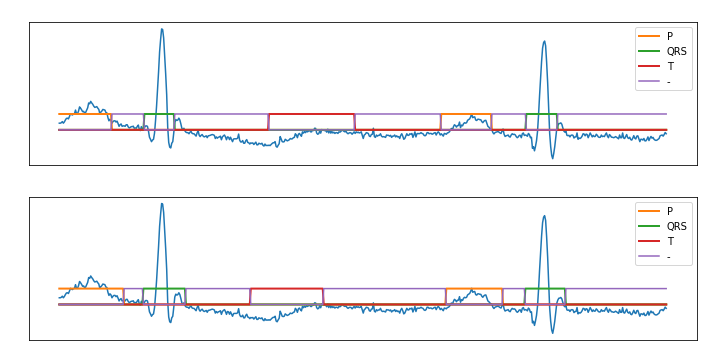

In [ ]:
sample_n = np.random.randint(0,len(vd_ecg_list))
print(sample_n)
ecg = vd_ecg_list[sample_n]
label = vd_label_list[sample_n] ## input

output = vd_output_list[sample_n] ## output
output = output_sliding_voting(output,7)

p = (output == 0)
N = (output == 1)
t = (output == 2)
r = (output == 3)


with plt.rc_context({'xtick.color':'white','ytick.color':'white'}):
    
    fig,axes = plt.subplots(2,1,figsize=(10,5))
    fig.tight_layout()
    
    axes[0].set_title("True boundary",color='white')
    axes[0].plot(ecg)
    axes[0].plot(label[0],label='P',linewidth=2)
    axes[0].legend(loc="upper right")
    axes[0].plot(label[1],label='QRS',linewidth=2)
    axes[0].plot(label[2],label='T',linewidth=2)
    axes[0].plot(label[3],label='-')
    axes[0].legend(loc="upper right")

    axes[1].set_title('Deep learnig Segmentation',color='white')
    axes[1].plot(ecg)
    axes[1].plot(p,label='P',linewidth=2)
    axes[1].plot(N,label='QRS',linewidth=2)
    axes[1].plot(t,label='T',linewidth=2)
    axes[1].plot(r,label='-')
    axes[1].legend(loc="upper right")

In [ ]:
input = [0 for _ in range(600)]
np.asarray(input)

for i in range(len(label)):
  input += label[i]*i
  
  

In [ ]:
input

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [ ]:
output

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [ ]:
### model accuracy 구현 ###

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
total_acc = []

for i in range(len(vd_label_list)):
  input = [0 for _ in range(600)]
  np.asarray(input)

  label = vd_label_list[i]

  output = vd_output_list[i] ## output
  output = output_sliding_voting(output,7)

  p = (output == 0)
  N = (output == 1)
  t = (output == 2)
  r = (output == 3)

  for i in range(len(label)):
    input += label[i]*i

  # print(accuracy_score(input, output))
  total_acc.append(accuracy_score(input, output))


print("model accuracy : ", sum(total_acc) / len(total_acc))

0.9333333333333333
0.9133333333333333
0.93
0.9483333333333334
0.935
0.94
0.935
0.9283333333333333
0.93
0.9333333333333333
0.94
0.945
0.94
0.9383333333333334
0.9416666666666667
0.945
0.9683333333333334
0.9783333333333334
0.8916666666666667
0.9433333333333334
0.94
0.9566666666666667
0.915
0.9216666666666666
0.95
0.95
0.96
0.965
0.8433333333333334
0.895
0.8716666666666667
0.6883333333333334
0.805
0.7683333333333333
0.7616666666666667
0.8683333333333333
0.835
0.885
0.7633333333333333
0.8
0.8583333333333333
0.945
0.935
0.935
0.8866666666666667
0.9283333333333333
0.9216666666666666
0.9066666666666666
0.9333333333333333
0.8816666666666667
0.9233333333333333
0.9066666666666666
0.9383333333333334
0.9266666666666666
0.9516666666666667
0.8333333333333334
0.8283333333333334
0.7883333333333333
0.7716666666666666
0.6483333333333333
0.815
0.7216666666666667
0.9433333333333334
0.965
0.9333333333333333
0.9
0.96
0.9816666666666667
0.9366666666666666
0.9566666666666667
0.79
0.94
0.95
0.9533333333333334
0

In [ ]:
## 성능평가 ##
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## y_pred, out_pred
print(accuracy_score(input, output))
print(recall_score(input, output, pos_label='positive', average='micro'))
print(precision_score(input, output, pos_label='positive', average='micro'))
print(f1_score(input, output, pos_label='positive', average='micro'))

0.8366666666666667
0.8366666666666667
0.8366666666666667
0.8366666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
